In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomRotate90(p=1),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



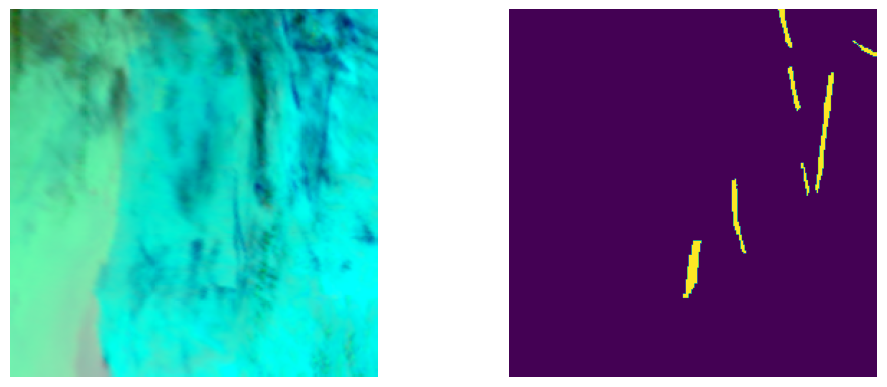

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(112, dataset_train)

# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 7.79GB  LR : 1.00E-04  Loss: 0.8063: 100%|██████████| 642/642 
Val Loss: 0.6404: 100%|██████████| 58/58 [00:03<00:00, 16.04it/s]               


FBeta : 0.5399	thresh : 0.27	SAVED MODEL



Epoch 1/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5186: 100%|██████████| 642/642 
Val Loss: 0.5441: 100%|██████████| 58/58 [00:03<00:00, 14.69it/s]               


FBeta : 0.5204	thresh : 0.01



Epoch 2/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4742: 100%|██████████| 642/642 
Val Loss: 0.5041: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s]               


FBeta : 0.5446	thresh : 0.01	SAVED MODEL



Epoch 3/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4597: 100%|██████████| 642/642 
Val Loss: 0.4936: 100%|██████████| 58/58 [00:03<00:00, 15.27it/s]               


FBeta : 0.5397	thresh : 0.59



Epoch 4/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4526: 100%|██████████| 642/642 
Val Loss: 0.4870: 100%|██████████| 58/58 [00:03<00:00, 15.57it/s]               


FBeta : 0.5540	thresh : 0.99	SAVED MODEL



Epoch 5/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4476: 100%|██████████| 642/642 
Val Loss: 0.5055: 100%|██████████| 58/58 [00:03<00:00, 15.39it/s]               


FBeta : 0.5399	thresh : 0.99



Epoch 6/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4422: 100%|██████████| 642/642 
Val Loss: 0.4613: 100%|██████████| 58/58 [00:03<00:00, 15.31it/s]               


FBeta : 0.5700	thresh : 0.25	SAVED MODEL



Epoch 7/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4362: 100%|██████████| 642/642 
Val Loss: 0.4626: 100%|██████████| 58/58 [00:03<00:00, 15.36it/s]               


FBeta : 0.5757	thresh : 0.99	SAVED MODEL



Epoch 8/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4320: 100%|██████████| 642/642 
Val Loss: 0.4509: 100%|██████████| 58/58 [00:03<00:00, 15.54it/s]               


FBeta : 0.5804	thresh : 0.27	SAVED MODEL



Epoch 9/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4340: 100%|██████████| 642/642 
Val Loss: 0.4653: 100%|██████████| 58/58 [00:03<00:00, 16.31it/s]               


FBeta : 0.5741	thresh : 0.01



Epoch 10/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4283: 100%|██████████| 642/642
Val Loss: 0.4567: 100%|██████████| 58/58 [00:03<00:00, 15.18it/s]               


FBeta : 0.5713	thresh : 0.55



Epoch 11/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4236: 100%|██████████| 642/642
Val Loss: 0.4551: 100%|██████████| 58/58 [00:03<00:00, 15.53it/s]               


FBeta : 0.5867	thresh : 0.01	SAVED MODEL



Epoch 12/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4218: 100%|██████████| 642/642
Val Loss: 0.4469: 100%|██████████| 58/58 [00:03<00:00, 15.25it/s]               


FBeta : 0.5864	thresh : 0.03



Epoch 13/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4207: 100%|██████████| 642/642
Val Loss: 0.4526: 100%|██████████| 58/58 [00:03<00:00, 16.42it/s]               


FBeta : 0.5780	thresh : 0.49



Epoch 14/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4177: 100%|██████████| 642/642
Val Loss: 0.4301: 100%|██████████| 58/58 [00:03<00:00, 15.09it/s]               


FBeta : 0.6038	thresh : 0.01	SAVED MODEL



Epoch 15/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4152: 100%|██████████| 642/642
Val Loss: 0.4350: 100%|██████████| 58/58 [00:03<00:00, 15.33it/s]               


FBeta : 0.5957	thresh : 0.01



Epoch 16/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4118: 100%|██████████| 642/642
Val Loss: 0.4277: 100%|██████████| 58/58 [00:03<00:00, 15.41it/s]               


FBeta : 0.6051	thresh : 0.11	SAVED MODEL



Epoch 17/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4103: 100%|██████████| 642/642
Val Loss: 0.4272: 100%|██████████| 58/58 [00:03<00:00, 16.29it/s]               


FBeta : 0.6032	thresh : 0.07



Epoch 18/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4114: 100%|██████████| 642/642
Val Loss: 0.4186: 100%|██████████| 58/58 [00:03<00:00, 15.19it/s]               


FBeta : 0.6095	thresh : 0.85	SAVED MODEL



Epoch 19/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4063: 100%|██████████| 642/642
Val Loss: 0.4235: 100%|██████████| 58/58 [00:03<00:00, 15.31it/s]               


FBeta : 0.6083	thresh : 0.97



Epoch 20/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4071: 100%|██████████| 642/642
Val Loss: 0.5323: 100%|██████████| 58/58 [00:03<00:00, 15.44it/s]               


FBeta : 0.5299	thresh : 0.01



Epoch 21/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4043: 100%|██████████| 642/642
Val Loss: 0.4126: 100%|██████████| 58/58 [00:03<00:00, 16.10it/s]               


FBeta : 0.6162	thresh : 0.01	SAVED MODEL



Epoch 22/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4010: 100%|██████████| 642/642
Val Loss: 0.4271: 100%|██████████| 58/58 [00:03<00:00, 15.10it/s]               


FBeta : 0.6017	thresh : 0.33



Epoch 23/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4007: 100%|██████████| 642/642
Val Loss: 0.4301: 100%|██████████| 58/58 [00:03<00:00, 15.27it/s]               


FBeta : 0.6024	thresh : 0.21



Epoch 24/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3991: 100%|██████████| 642/642
Val Loss: 0.4327: 100%|██████████| 58/58 [00:03<00:00, 16.62it/s]               


FBeta : 0.6037	thresh : 0.99



Epoch 25/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3968: 100%|██████████| 642/642
Val Loss: 0.4047: 100%|██████████| 58/58 [00:03<00:00, 15.19it/s]               


FBeta : 0.6211	thresh : 0.09	SAVED MODEL



Epoch 26/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3929: 100%|██████████| 642/642
Val Loss: 0.4346: 100%|██████████| 58/58 [00:03<00:00, 15.15it/s]               


FBeta : 0.6022	thresh : 0.99



Epoch 27/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3934: 100%|██████████| 642/642
Val Loss: 0.4109: 100%|██████████| 58/58 [00:03<00:00, 15.52it/s]               


FBeta : 0.6160	thresh : 0.41



Epoch 28/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3943: 100%|██████████| 642/642
Val Loss: 0.4248: 100%|██████████| 58/58 [00:03<00:00, 15.36it/s]               


FBeta : 0.6101	thresh : 0.01



Epoch 29/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3916: 100%|██████████| 642/642
Val Loss: 0.4065: 100%|██████████| 58/58 [00:03<00:00, 16.19it/s]               


FBeta : 0.6187	thresh : 0.01



Epoch 30/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3914: 100%|██████████| 642/642
Val Loss: 0.4184: 100%|██████████| 58/58 [00:05<00:00, 11.00it/s]               


FBeta : 0.6124	thresh : 0.01



Epoch 31/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3894: 100%|██████████| 642/642
Val Loss: 0.4058: 100%|██████████| 58/58 [00:03<00:00, 15.10it/s]               


FBeta : 0.6177	thresh : 0.03



Epoch 32/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3899: 100%|██████████| 642/642
Val Loss: 0.4078: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6227	thresh : 0.65	SAVED MODEL



Epoch 33/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3865: 100%|██████████| 642/642
Val Loss: 0.4050: 100%|██████████| 58/58 [00:03<00:00, 16.04it/s]               


FBeta : 0.6225	thresh : 0.99



Epoch 34/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3857: 100%|██████████| 642/642
Val Loss: 0.4019: 100%|██████████| 58/58 [00:03<00:00, 14.82it/s]               


FBeta : 0.6230	thresh : 0.97	SAVED MODEL



Epoch 35/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3847: 100%|██████████| 642/642
Val Loss: 0.3980: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6276	thresh : 0.03	SAVED MODEL



Epoch 36/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3827: 100%|██████████| 642/642
Val Loss: 0.4105: 100%|██████████| 58/58 [00:03<00:00, 15.21it/s]               


FBeta : 0.6188	thresh : 0.45



Epoch 37/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3801: 100%|██████████| 642/642
Val Loss: 0.4260: 100%|██████████| 58/58 [00:03<00:00, 16.23it/s]               


FBeta : 0.6108	thresh : 0.01



Epoch 38/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3812: 100%|██████████| 642/642
Val Loss: 0.4085: 100%|██████████| 58/58 [00:03<00:00, 15.13it/s]               


FBeta : 0.6209	thresh : 0.03



Epoch 39/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3791: 100%|██████████| 642/642
Val Loss: 0.4086: 100%|██████████| 58/58 [00:03<00:00, 15.09it/s]               


FBeta : 0.6224	thresh : 0.01



Epoch 40/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3762: 100%|██████████| 642/642
Val Loss: 0.3988: 100%|██████████| 58/58 [00:03<00:00, 14.96it/s]               


FBeta : 0.6296	thresh : 0.11	SAVED MODEL



Epoch 41/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3750: 100%|██████████| 642/642
Val Loss: 0.4092: 100%|██████████| 58/58 [00:03<00:00, 15.14it/s]               


FBeta : 0.6225	thresh : 0.01



Epoch 42/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3763: 100%|██████████| 642/642
Val Loss: 0.3961: 100%|██████████| 58/58 [00:03<00:00, 15.29it/s]               


FBeta : 0.6338	thresh : 0.03	SAVED MODEL



Epoch 43/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3736: 100%|██████████| 642/642
Val Loss: 0.4021: 100%|██████████| 58/58 [00:03<00:00, 15.27it/s]               


FBeta : 0.6279	thresh : 0.01



Epoch 44/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3697: 100%|██████████| 642/642
Val Loss: 0.3972: 100%|██████████| 58/58 [00:03<00:00, 15.34it/s]               


FBeta : 0.6297	thresh : 0.63



Epoch 45/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3729: 100%|██████████| 642/642
Val Loss: 0.4013: 100%|██████████| 58/58 [00:03<00:00, 16.05it/s]               


FBeta : 0.6259	thresh : 0.03



Epoch 46/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3703: 100%|██████████| 642/642
Val Loss: 0.3977: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.6284	thresh : 0.93



Epoch 47/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3679: 100%|██████████| 642/642
Val Loss: 0.3968: 100%|██████████| 58/58 [00:03<00:00, 14.70it/s]               


FBeta : 0.6274	thresh : 0.97



Epoch 48/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3672: 100%|██████████| 642/642
Val Loss: 0.3964: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6303	thresh : 0.09



Epoch 49/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3677: 100%|██████████| 642/642
Val Loss: 0.3986: 100%|██████████| 58/58 [00:03<00:00, 15.08it/s]               


FBeta : 0.6279	thresh : 0.01



Epoch 50/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3651: 100%|██████████| 642/642
Val Loss: 0.3938: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s]               


FBeta : 0.6334	thresh : 0.27



Epoch 51/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3639: 100%|██████████| 642/642
Val Loss: 0.3986: 100%|██████████| 58/58 [00:03<00:00, 14.87it/s]               


FBeta : 0.6283	thresh : 0.03



Epoch 52/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3606: 100%|██████████| 642/642
Val Loss: 0.3943: 100%|██████████| 58/58 [00:03<00:00, 15.45it/s]               


FBeta : 0.6313	thresh : 0.01



Epoch 53/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3606: 100%|██████████| 642/642
Val Loss: 0.3974: 100%|██████████| 58/58 [00:03<00:00, 16.21it/s]               


FBeta : 0.6312	thresh : 0.01



Epoch 54/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3600: 100%|██████████| 642/642
Val Loss: 0.3910: 100%|██████████| 58/58 [00:03<00:00, 15.01it/s]               


FBeta : 0.6347	thresh : 0.67	SAVED MODEL



Epoch 55/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3600: 100%|██████████| 642/642
Val Loss: 0.3924: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6340	thresh : 0.07



Epoch 56/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3569: 100%|██████████| 642/642
Val Loss: 0.3966: 100%|██████████| 58/58 [00:03<00:00, 16.48it/s]               


FBeta : 0.6278	thresh : 0.95



Epoch 57/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3576: 100%|██████████| 642/642
Val Loss: 0.3914: 100%|██████████| 58/58 [00:03<00:00, 14.83it/s]               


FBeta : 0.6325	thresh : 0.13



Epoch 58/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3549: 100%|██████████| 642/642
Val Loss: 0.3940: 100%|██████████| 58/58 [00:03<00:00, 16.56it/s]               


FBeta : 0.6321	thresh : 0.01



Epoch 59/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3545: 100%|██████████| 642/642
Val Loss: 0.3925: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6335	thresh : 0.15



Epoch 60/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3518: 100%|██████████| 642/642
Val Loss: 0.3962: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6312	thresh : 0.55



Epoch 61/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3506: 100%|██████████| 642/642
Val Loss: 0.3927: 100%|██████████| 58/58 [00:03<00:00, 16.41it/s]               


FBeta : 0.6335	thresh : 0.09



Epoch 62/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3513: 100%|██████████| 642/642
Val Loss: 0.3875: 100%|██████████| 58/58 [00:03<00:00, 15.13it/s]               


FBeta : 0.6382	thresh : 0.01	SAVED MODEL



Epoch 63/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3496: 100%|██████████| 642/642
Val Loss: 0.3919: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.6350	thresh : 0.03



Epoch 64/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3511: 100%|██████████| 642/642
Val Loss: 0.3919: 100%|██████████| 58/58 [00:03<00:00, 16.05it/s]               


FBeta : 0.6348	thresh : 0.01



Epoch 65/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3492: 100%|██████████| 642/642
Val Loss: 0.3888: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.6368	thresh : 0.39



Epoch 66/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3468: 100%|██████████| 642/642
Val Loss: 0.3919: 100%|██████████| 58/58 [00:03<00:00, 14.91it/s]               


FBeta : 0.6361	thresh : 0.01



Epoch 67/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3481: 100%|██████████| 642/642
Val Loss: 0.3922: 100%|██████████| 58/58 [00:03<00:00, 15.31it/s]               


FBeta : 0.6354	thresh : 0.01



Epoch 68/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3448: 100%|██████████| 642/642
Val Loss: 0.3898: 100%|██████████| 58/58 [00:03<00:00, 15.86it/s]               


FBeta : 0.6366	thresh : 0.01



Epoch 69/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3433: 100%|██████████| 642/642
Val Loss: 0.3913: 100%|██████████| 58/58 [00:03<00:00, 14.88it/s]               


FBeta : 0.6374	thresh : 0.05



Epoch 70/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3445: 100%|██████████| 642/642
Val Loss: 0.3936: 100%|██████████| 58/58 [00:03<00:00, 15.07it/s]               


FBeta : 0.6343	thresh : 0.01



Epoch 71/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3425: 100%|██████████| 642/642
Val Loss: 0.3918: 100%|██████████| 58/58 [00:03<00:00, 16.16it/s]               


FBeta : 0.6344	thresh : 0.01



Epoch 72/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3417: 100%|██████████| 642/642
Val Loss: 0.3881: 100%|██████████| 58/58 [00:03<00:00, 15.24it/s]               


FBeta : 0.6381	thresh : 0.13



Epoch 73/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3422: 100%|██████████| 642/642
Val Loss: 0.3885: 100%|██████████| 58/58 [00:03<00:00, 15.06it/s]               


FBeta : 0.6387	thresh : 0.01	SAVED MODEL



Epoch 74/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3413: 100%|██████████| 642/642
Val Loss: 0.3899: 100%|██████████| 58/58 [00:03<00:00, 15.13it/s]               


FBeta : 0.6374	thresh : 0.01



Epoch 75/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3393: 100%|██████████| 642/642
Val Loss: 0.3885: 100%|██████████| 58/58 [00:03<00:00, 15.67it/s]               


FBeta : 0.6384	thresh : 0.09



Epoch 76/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3425: 100%|██████████| 642/642
Val Loss: 0.3901: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6367	thresh : 0.17



Epoch 77/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3409: 100%|██████████| 642/642
Val Loss: 0.3885: 100%|██████████| 58/58 [00:03<00:00, 15.09it/s]               


FBeta : 0.6387	thresh : 0.01



Epoch 78/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3384: 100%|██████████| 642/642
Val Loss: 0.3901: 100%|██████████| 58/58 [00:03<00:00, 15.34it/s]               


FBeta : 0.6380	thresh : 0.03



Epoch 79/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3376: 100%|██████████| 642/642
Val Loss: 0.3914: 100%|██████████| 58/58 [00:03<00:00, 16.11it/s]               


FBeta : 0.6373	thresh : 0.01



Epoch 80/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3370: 100%|██████████| 642/642
Val Loss: 0.3899: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6374	thresh : 0.03



Epoch 81/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3383: 100%|██████████| 642/642
Val Loss: 0.3888: 100%|██████████| 58/58 [00:03<00:00, 15.26it/s]               


FBeta : 0.6380	thresh : 0.03



Epoch 82/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3370: 100%|██████████| 642/642
Val Loss: 0.3900: 100%|██████████| 58/58 [00:03<00:00, 16.48it/s]               


FBeta : 0.6374	thresh : 0.05



Epoch 83/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3361: 100%|██████████| 642/642
Val Loss: 0.3872: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.6392	thresh : 0.17	SAVED MODEL



Epoch 84/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3352: 100%|██████████| 642/642
Val Loss: 0.3887: 100%|██████████| 58/58 [00:03<00:00, 15.14it/s]               


FBeta : 0.6385	thresh : 0.01



Epoch 85/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3360: 100%|██████████| 642/642
Val Loss: 0.3882: 100%|██████████| 58/58 [00:03<00:00, 15.28it/s]               


FBeta : 0.6382	thresh : 0.03



Epoch 86/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3356: 100%|██████████| 642/642
Val Loss: 0.3877: 100%|██████████| 58/58 [00:03<00:00, 16.05it/s]               


FBeta : 0.6384	thresh : 0.03



Epoch 87/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3352: 100%|██████████| 642/642
Val Loss: 0.3876: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.6387	thresh : 0.07



Epoch 88/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3362: 100%|██████████| 642/642
Val Loss: 0.3874: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6388	thresh : 0.05



Epoch 89/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3381: 100%|██████████| 642/642
Val Loss: 0.3876: 100%|██████████| 58/58 [00:03<00:00, 15.28it/s]               


FBeta : 0.6389	thresh : 0.03

{"status":200,"message":"ok"}

In [9]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.6392


In [10]:
# for i, (images, masks) in enumerate(dataloader_valid):
#     if i!=1: continue
    
#     images, masks = images.cuda(), masks.cuda()
#     with torch.no_grad():
#         preds = model(images)
#         preds = torch.sigmoid(preds)
#     images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
#     for num in range(CFG.valid_batch_size):
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
#         axes = axes.flatten()
#         axes[0].imshow(images[num].permute(1,2,0))
#         axes[0].axis('off')
#         axes[0].set_title('Image')
#         axes[1].imshow(masks[num].permute(1,2,0))
#         axes[1].axis('off')
#         axes[1].set_title('Ground Truth')
#         axes[2].imshow(preds[num].permute(1,2,0))
#         axes[2].axis('off')
#         axes[2].set_title('pred')
#         axes[3].imshow((preds[num]>thresh).permute(1,2,0))
#         axes[3].axis('off')
#         axes[3].set_title('pred_thresh')
#     break